# Linear Regression on House Prices with XGBoost

In [1]:
keras_actif = True # Active Keras ou XGBoost
if keras_actif:
    xgb_actif = False
else:
    xgb_actif = True

## Preprocess data

In [2]:
import pandas as pd
import numpy as np
from numpy import transpose
from numpy import append
from numpy import reshape
import matplotlib.pyplot as plt
# %matplotlib notebook
import seaborn as sns

np.random.seed(42)
# tf.random.set_seed(42)
pd.set_option('display.max_columns', 100)

In [3]:
data = pd.read_csv('sources/train.csv')
data.drop('Id',axis = 1, inplace = True)
data.fillna(0, inplace=True)
data_num = data.select_dtypes(exclude=['object'])
data_cat = data.select_dtypes(include=['object'])

data_test = pd.read_csv('sources/test.csv')
data_test_id = data_test['Id']
data_test.drop('Id',axis = 1, inplace = True)
data_test.fillna(0, inplace=True)
data_test_num = data_test.select_dtypes(exclude=['object'])
data_test_cat = data_test.select_dtypes(include=['object'])

# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    data[col].fillna('None',inplace=True)
    data_test[col].fillna('None',inplace=True)

# Convert categorical variable into dummy/indicator variables.
data_cat = pd.get_dummies(data_cat)
data_test_cat = pd.get_dummies(data_test_cat)

print(f"Shape data : {data.shape}")
print(f"Shape data_num : {data_num.shape}")
print(f"Shape data_cat après get_dummies : {data_cat.shape}")
# print('')
# print(f"Features numériques : {list(data_num.columns)}")
# print('')
# print(f"Features catégorielles : {list(data_cat.columns)}")
print('')
print(f"Shape data_test : {data_test.shape}")
print(f"Shape data_test_num : {data_test_num.shape}")
print(f"Shape data_test_cat après get_dummies : {data_test_cat.shape}")
# print('')
# print(f"Features numériques : {list(data_test_num.columns)}")
# print('')
# print(f"Features catégorielles : {list(data_test_cat.columns)}")
# print('')

Shape data : (1460, 80)
Shape data_num : (1460, 37)
Shape data_cat après get_dummies : (1460, 268)

Shape data_test : (1459, 79)
Shape data_test_num : (1459, 36)
Shape data_test_cat après get_dummies : (1459, 256)


### Delete outliers

In [4]:
# Suppression des outliers
remove_outliers = True
if remove_outliers:
    from sklearn.ensemble import IsolationForest
    
    anomalies_ratio = 0.01
    clf = IsolationForest(contamination = anomalies_ratio,
                          behaviour= " new",
                          random_state = 42)

    clf.fit(data_num)
    y_noano = clf.predict(data_num)
    
    y_noano = pd.DataFrame(y_noano, columns = ['Top'])
    y_noano[y_noano['Top'] == 1].index.values

    data_num = data_num.iloc[y_noano[y_noano['Top'] == 1].index.values]
    data_num.reset_index(drop = True, inplace = True)
    
    data_cat = data_cat.iloc[y_noano[y_noano['Top'] == 1].index.values]
    data_cat.reset_index(drop = True, inplace = True)
    print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
    print("Number of rows without outliers:", data_num.shape[0])

Number of Outliers: 15
Number of rows without outliers: 1445


In [5]:
data[data['SaleCondition'] == 'Partial'].shape[0]

125

### Merge Num & Cat Dataset

In [6]:
# data = pd.concat([data_num, data_cat], ignore_index=False, axis=1)
data = pd.concat([data_num, data_cat], ignore_index=False, axis=1)
data_test = pd.concat([data_test_num, data_test_cat], ignore_index=False, axis=1)
print(f"Shape data : {data.shape}")
print(f"Shape data_test : {data_test.shape}")

Shape data : (1445, 305)
Shape data_test : (1459, 292)


### Add missing columns to data_test

In [7]:
# Reshape colonne similaire
missing_col = list(set(data.columns) - set(data_test.columns))
print(missing_col)
print('')

for col in missing_col:
    data_test[col] = 0
data_test = data_test[data.columns]

print(f"Shape data : {data.shape}")
print(f"Shape data_test : {data_test.shape}")
print('')
missing_col = list(set(data.columns) - set(data_test.columns))
print(missing_col)

['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'SalePrice', 'Condition2_RRAn', 'Electrical_0', 'Condition2_RRNn', 'RoofMatl_Roll', 'RoofMatl_Metal', 'GarageQual_Ex', 'PoolQC_Fa', 'Electrical_Mix', 'Utilities_NoSeWa', 'Exterior2nd_Other', 'Heating_OthW', 'RoofMatl_Membran', 'Exterior1st_Stone', 'Heating_Floor', 'RoofMatl_ClyTile', 'MiscFeature_TenC', 'Condition2_RRAe']

Shape data : (1445, 305)
Shape data_test : (1459, 305)

[]


### Extract SalePrice from data

In [8]:
if 'SalePrice' in data.columns:
    Y_train = np.log(data['SalePrice']).to_numpy()
    Y_train = Y_train.reshape(Y_train.shape[0],1)
    del data['SalePrice']
    del data_test['SalePrice']

X_train = data.to_numpy()
X_test = data_test.to_numpy()

print(f"X train {X_train.shape}")
print(f"Y train {Y_train.shape}")
print(f"X test {X_test.shape}")

X train (1445, 304)
Y train (1445, 1)
X test (1459, 304)


### Scale features

"Normalizing" the data should help prevent values from "exploding":

In [9]:
scale_data = True
if scale_data:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    scaler_Y = scaler.fit(Y_train)
    Y_train = scaler_Y.transform(Y_train)
    
print(f"X train {X_train.shape}")
print(f"Y train {Y_train.shape}")
print(f"X test {X_test.shape}")

X train (1445, 304)
Y train (1445, 1)
X test (1459, 304)


## Modelling

### Keras

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from keras import metrics

import tensorflow.keras.backend as K
def RMSE(y, yh):
    return K.sqrt(K.mean(K.square(yh-y)))

def create_model():
    model = Sequential([
        Input(shape=X_train.shape[1]),
        Dropout(0.1),
        Dense(28, activation='relu'),
        Dense(14, activation='relu'),
        Dense(1)
    ])
    return model

In [119]:
if keras_actif:
    optimisation_flow = True
    if optimisation_flow:
        from sklearn.model_selection import train_test_split
        X_split_train, X_split_val, y_split_train, y_split_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

    model = create_model()
    print(model.summary())

    from tensorflow.keras.optimizers import Adam
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False),
        metrics=['mae', RMSE] # metrics=['mae', 'msle']
    )

    BATCH_SIZE = X_train.shape[1] #
    
    history = {}
    for i in range(100, 501, 100):
        EPOCHS = i # how many iterations over the whole dataset
        
        if optimisation_flow:
            evaluations = {}
            history[i] = model.fit(X_split_train, y_split_train, validation_data=(X_split_val, y_split_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        else:
            history[i] = model.fit(X_train, Y_train, validation_data=(X_train, Y_train), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

        hist = pd.DataFrame(history[i].history)
        
        print(f"Nombre d'EPOCHS : {i}")
        print(f"RMSE Trainset : {hist.tail(1)['RMSE'].values[0]}")
        print(f"RMSE Valset   : {hist.tail(1)['val_RMSE'].values[0]}")
        print(f"MAE Trainset : {hist.tail(1)['mean_absolute_error'].values[0]}")
        print(f"MAE Valset   : {hist.tail(1)['val_mean_absolute_error'].values[0]}")
        print('')

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 304)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 28)                8540      
_________________________________________________________________
dense_121 (Dense)            (None, 14)                406       
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 15        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________
None
Nombre d'EPOCHS : 100
RMSE Trainset : 0.14904457330703735
RMSE Valset   : 0.4122183322906494
MAE Trainset : 0.10826674103736877
MAE Valset   : 0.265642911195755

Nombre d'EPOCHS : 200
RMSE Trainset : 0.114163339138031
RMSE Valset   : 0.38223645

In [104]:
hist.head()

,loss,mean_absolute_error,RMSE,val_loss,val_mean_absolute_error,val_RMSE
0,0.011228,0.059502,0.105714,0.151325,0.268863,0.389005
1,0.011191,0.059415,0.105865,0.151367,0.268897,0.389059
2,0.011162,0.059335,0.105334,0.151357,0.268921,0.389046
3,0.011137,0.059285,0.105836,0.151317,0.268885,0.388995
4,0.011100,0.059129,0.103673,0.151282,0.268847,0.388950


In [92]:
print(f"MAE Trainset : {hist.tail(1)['mean_absolute_error'].values[0]}")
print(f"MAE Valset   : {hist.tail(1)['val_mean_absolute_error'].values[0]}")

MAE Trainset : 0.010961384512484074
MAE Valset   : 0.29218393564224243


In [90]:
print(f"MAE Trainset : {hist.tail(1)['mean_absolute_error'].values[0]}")
print(f"MAE Valset   : {hist.tail(1)['val_mean_absolute_error'].values[0]}")

MAE Trainset : 0.14404259622097015
MAE Valset   : 0.2754118740558624


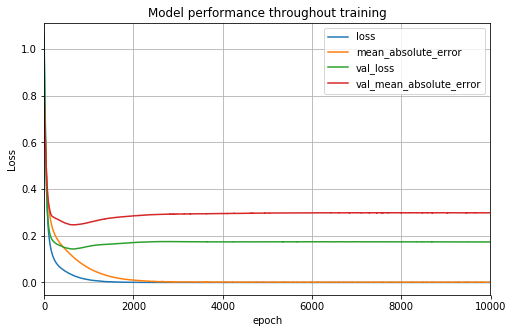

In [76]:
hist.plot(figsize=(8, 5))#, logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

### XGBRegressor

In [15]:
if xgb_actif:
    import xgboost as xgb
    
    optimisation_gridsearchCV = False
    if optimisation_gridsearchCV:
        from sklearn.model_selection import GridSearchCV
        gb_model = xgb.XGBRegressor(objective='reg:squarederror')
        params = {
            'kernel':('linear', 'poly', 'poly', 'rbf', 'rbf'),
            'min_child_weight':[4,5],
            'gamma':[i/10.0 for i in range(3,6)],
            'subsample':[i/10.0 for i in range(6,11)],
            'colsample_bytree':[i/10.0 for i in range(6,11)],
            'max_depth': [2,3,4]
        }

        xgb_model = GridSearchCV(xgb_model, params)
        xgb_model.fit(X_train, Y_train)

        xgb_model.best_estimator_
    else:
        xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
             importance_type='gain', kernel='linear', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8, verbosity=1)
        
        xgb_model.fit(X_train, Y_train)
    
    optimisation_flow = True
    if optimisation_flow:
        from sklearn import metrics
        from sklearn.model_selection import train_test_split
        X_split_train,X_split_test, y_split_train, y_split_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
        xgb_split = xgb.XGBRegressor()
        XgBoost = xgb_split.fit(X_split_train, y_split_train)
        Y_train_pred_80 = xgb_split.predict(X_split_train) # Prediction sur train (80%)
        Y_train_pred_20 = xgb_split.predict(X_split_test) # Prediction sur val (20%)

        print(' > Results on train :')
#         print(' >> RMSLE : ', np.sqrt(metrics.mean_squared_log_error(y_split_train, Y_train_pred_80)))
        print(' >> MAE : ', metrics.mean_absolute_error(y_split_train, Y_train_pred_80))
        print()

        print (' > Results on val :')
#         print(' >> RMSLE : ', np.sqrt(metrics.mean_squared_log_error(y_split_test, Y_train_pred_20)))
        print(' >> MAE : ', metrics.mean_absolute_error(y_split_test, Y_train_pred_20))
        print()    

[15:05:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 > Results on train :
 >> MAE :  0.14452049727628635

 > Results on val :
 >> MAE :  0.2131217520585995



## Prepare for Kaggle submisison

In [12]:
if keras_actif:
    Y_test = model.predict(x=X_test)
if xgb_actif:
    Y_test = xgb_model.predict(X_test)

Y_test = np.exp(scaler_Y.inverse_transform(Y_test))
Y_test = np.reshape(Y_test, Y_test.shape[0],)

In [13]:
data_test['Id'] = data_test_id
data_test['SalePrice'] = Y_test
data_test.drop(data_test.columns.difference(['Id','SalePrice']), 1, inplace=True)
data_test.to_csv('storage/allfeatures_.csv', index=False)